# Graph neural network for Schelling games

In this notebook we are going to use GNN to predict whether assignement is in maximal social welfare at equilibrium (MSWE) or not. Furthermore, we compare our model performance on both tree and general graphs.

## Predicting maximal social welfare at equilibirum for tree graphs

We start by creating our own dataset from random graphs with random numbers of strategic and stubborn agents.


In [1]:
import os.path as osp
import torch
from torch_geometric.utils import to_networkx
from torch_geometric.data import Dataset
import networkx as nx # we can use networkx to display graphs in dataset

In [2]:
num_data_files = 1150 # here we choose number of graphs to train on, maximum is 1150
class SchellingDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return 'not_implemented.pt'

    @property
    def processed_file_names(self):
        return [f'data_{i}.pt' for i in range(num_data_files)]
    
    def download(self):
        pass

    def process(self):
        pass
    
    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data    

### Print info about our dataset

In [3]:
dataset = SchellingDataset(root='datasets/trees/')

print('**Dataset information:**')
print()
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


nodes = []
edges = []
for graph in dataset:
    nodes.append(graph.num_nodes)
    edges.append(graph.num_edges)

print(f'Average number of nodes: {sum(nodes) / len(nodes)}')
print(f'Average number of edges: {sum(edges) / len(edges)}')
print(f'Size of the dataset: {len(dataset)}')

**Dataset information:**

Number of graphs: 1150
Number of features: 6
Number of classes: 2
Average number of nodes: 12.16
Average number of edges: 22.32
Size of the dataset: 1150


### Preprocessing data

In [4]:
# set random seed and shuffle dataset
torch.manual_seed(0)
dataset = dataset.shuffle()

In [5]:
train_size = int(len(dataset) * 0.8) # we use 0.8 of the dataset to train our network
train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

print(len(train_dataset), len(test_dataset))

920 230


In [6]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def print_batches():
    for step, data in enumerate(train_loader):
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()
# here we can print info about batches
print_batches()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[802, 6], edge_index=[2, 1476], y=[64], batch=[802], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[781, 6], edge_index=[2, 1434], y=[64], batch=[781], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[819, 6], edge_index=[2, 1510], y=[64], batch=[819], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[748, 6], edge_index=[2, 1368], y=[64], batch=[748], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[798, 6], edge_index=[2, 1468], y=[64], batch=[798], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[761, 6], edge_index=[2, 1394], y=[64], batch=[761], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[777, 6], edge_index=[2, 1426], y=[64], batch=[777], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[772, 6], edge_index=[2, 1416], y=[64], batch=[772], ptr

### Implementing GNN
Here we implement our GNN. In our model we use three convolutional layers and two linear layers.

In [7]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, 32)
        self.lin2 = Linear(32, dataset.num_classes)
        

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = torch.sigmoid(self.lin1(x))
        x = self.lin2(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GraphConv(6, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)


In [9]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x.float(), data.edge_index.long(), data.batch.long())  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x.float(), data.edge_index.long(), data.batch.long())  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

### Training our GNN for tree graphs

In [10]:
max_accuracy, best_epoch = 0, 0
epochs = []
test_accuracy = []
train_accuracy = []

for epoch in range(0,200):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    
    if (test_acc > max_accuracy):
        max_accuracy, best_epoch = test_acc, epoch
    
    if epoch % 10 == 0:
        # append for graph
        test_accuracy.append(test_acc)
        train_accuracy.append(train_acc)
        epochs.append(epoch)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.5837, Test Acc: 0.5000
Epoch: 010, Train Acc: 0.8413, Test Acc: 0.8609
Epoch: 020, Train Acc: 0.8870, Test Acc: 0.8826
Epoch: 030, Train Acc: 0.9098, Test Acc: 0.8565
Epoch: 040, Train Acc: 0.9163, Test Acc: 0.8696
Epoch: 050, Train Acc: 0.9207, Test Acc: 0.8609
Epoch: 060, Train Acc: 0.9304, Test Acc: 0.8565
Epoch: 070, Train Acc: 0.9326, Test Acc: 0.8870
Epoch: 080, Train Acc: 0.9261, Test Acc: 0.8565
Epoch: 090, Train Acc: 0.9446, Test Acc: 0.8783
Epoch: 100, Train Acc: 0.9543, Test Acc: 0.8826
Epoch: 110, Train Acc: 0.9511, Test Acc: 0.8826
Epoch: 120, Train Acc: 0.9707, Test Acc: 0.9000
Epoch: 130, Train Acc: 0.9630, Test Acc: 0.9000
Epoch: 140, Train Acc: 0.9783, Test Acc: 0.8957
Epoch: 150, Train Acc: 0.9793, Test Acc: 0.9130
Epoch: 160, Train Acc: 0.9728, Test Acc: 0.9000
Epoch: 170, Train Acc: 0.9783, Test Acc: 0.8826
Epoch: 180, Train Acc: 0.9467, Test Acc: 0.8913
Epoch: 190, Train Acc: 0.9511, Test Acc: 0.8783


In [11]:
print(f'Best accuracy achieved and epoch: {max_accuracy}, {best_epoch}')

Best accuracy achieved and epoch: 0.9173913043478261, 142


In [12]:
def plot_result(epochs, train_accuracy, test_accuracy):
    """
    Function plots accuracies on test and train datasets.
    """
    import matplotlib.pyplot as plt
    plt.plot(epochs, train_accuracy, label="train accuracy")
    plt.plot(epochs, test_accuracy, label="test accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    # plt.savefig('tree_gnn.png', dpi=300)
    plt.show()

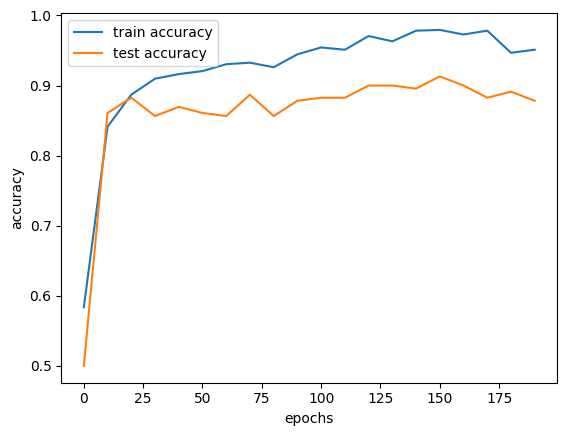

In [13]:
plot_result(epochs, train_accuracy, test_accuracy)

In [14]:
# you can save your model if you want
# torch.save(model, "models/model1")

## Predicting maximial social welfare at equilibirum for general graphs

In [15]:
dataset = SchellingDataset(root='datasets/general')

print('**Dataset information:**')
print()
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


nodes = []
edges = []
for graph in dataset:
    nodes.append(graph.num_nodes)
    edges.append(graph.num_edges)

print(f'Average number of nodes: {sum(nodes) / len(nodes)}')
print(f'Average number of edges: {sum(edges) / len(edges)}')
print(f'Size of the dataset: {len(dataset)}')

**Dataset information:**

Number of graphs: 1150
Number of features: 6
Number of classes: 2
Average number of nodes: 12.497391304347826
Average number of edges: 78.67130434782608
Size of the dataset: 1150


### Preprocessing

In [16]:
dataset = dataset.shuffle()

In [17]:
train_size = int (len(dataset) * 0.8) # we use same size of train dataset here as well
train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

# sizes of our datasets
print(len(train_dataset), len(test_dataset))

920 230


In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# here we can again print batches info again
# print_batches()

In [19]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

### Training our GNN for general graphs

In [20]:
max_accuracy, best_epoch = 0, 0
epochs = []
test_accuracy = []
train_accuracy = []

for epoch in range(0,200):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    
    if (test_acc > max_accuracy):
        max_accuracy, best_epoch = test_acc, epoch
    
    if epoch % 10 == 0:
        # append for graph
        test_accuracy.append(test_acc)
        train_accuracy.append(train_acc)
        epochs.append(epoch)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.5163, Test Acc: 0.5652
Epoch: 010, Train Acc: 0.5554, Test Acc: 0.6000
Epoch: 020, Train Acc: 0.6185, Test Acc: 0.6565
Epoch: 030, Train Acc: 0.6391, Test Acc: 0.6913
Epoch: 040, Train Acc: 0.6609, Test Acc: 0.6783
Epoch: 050, Train Acc: 0.6565, Test Acc: 0.7000
Epoch: 060, Train Acc: 0.6261, Test Acc: 0.6478
Epoch: 070, Train Acc: 0.6446, Test Acc: 0.6826
Epoch: 080, Train Acc: 0.6826, Test Acc: 0.7391
Epoch: 090, Train Acc: 0.6880, Test Acc: 0.7087
Epoch: 100, Train Acc: 0.7283, Test Acc: 0.7217
Epoch: 110, Train Acc: 0.7337, Test Acc: 0.7652
Epoch: 120, Train Acc: 0.6859, Test Acc: 0.6913
Epoch: 130, Train Acc: 0.7076, Test Acc: 0.7043
Epoch: 140, Train Acc: 0.7033, Test Acc: 0.6826
Epoch: 150, Train Acc: 0.7478, Test Acc: 0.7435
Epoch: 160, Train Acc: 0.8022, Test Acc: 0.7739
Epoch: 170, Train Acc: 0.7804, Test Acc: 0.7696
Epoch: 180, Train Acc: 0.8098, Test Acc: 0.8087
Epoch: 190, Train Acc: 0.8000, Test Acc: 0.8087


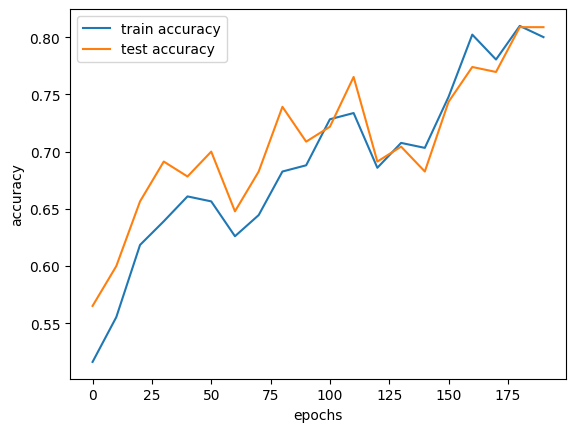

In [21]:
plot_result(epochs, train_accuracy, test_accuracy)

In [22]:
# you can save your model if you want
# torch.save(model, "models/model2")